In [88]:
# import all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import math

In [89]:
# load csv
base_df = pd.read_csv('atp_transformed/2000-2024 players_3.csv')

C:\Users\jesse\AppData\Local\Temp\ipykernel_30044\872059729.py:2: DtypeWarning: Columns (18,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  base_df = pd.read_csv('atp_transformed/2000-2024 players_3.csv')


In [90]:
full_df = base_df
len(full_df)

1282807

In [91]:
selected_features = [
# 'surface', 
'tourney_level', 
# 'tourney_date', # dropped because not numeric 
'match_num', 
#'player_height', 
# 'player_country', 
'player_age', 
# 'elo_pre_match', # dropped because of colinearity
# 'opponent_elo_pre_match', 
#'opponent_rank', 
# 'mean_numb', # dropped as the rolling means are derrivitives of these columns and adding the raw ones creates a worse model and increases conlinearity
# 'median_numb', 
# 'total_numb', 
# 'mean_diff', 
# 'median_diff', 
# 'total_diff', 
# 'mean_tb_numb', 
# 'median_tb_numb', 
# 'total_tb_numb', 
# 'mean_tb_diff', 
# 'median_tb_diff', 
# 'total_tb_diff', 
'days_of_experience',
# 'career_year', 
# 'rest_days', 
# 'set_dominance', 
# 'tb_dominance', 
#'highest_finish_position', 
'draw_size_rolling_med_10', 
'highest_finish_position_rolling_med_10', 
# 'ace_rolling_mean_10', 
# 'double_faults_rolling_mean_10', # drop these so that most low level players are included
# 'points_on_serve_rolling_mean_10', 
# 'first_serve_in_rolling_mean_10', 
# '1stWon_rolling_mean_10', 
# '2ndWon_rolling_mean_10', 
# 'service_games_rolling_mean_10', 
# 'break_points_saved_rolling_mean_10', 
# 'break_points_faced_rolling_mean_10', 
'elo_pre_match_rolling_mean_10',
'opponent_elo_pre_match_rolling_mean_10', 
'set_dominance_rolling_mean_10', 
'tb_dominance_rolling_mean_10', 
#'player_rank_rolling_mean_10', # dropped because the model will cheat with this if predicting rank
'mean_numb_rolling_mean_10', 
#'median_numb_rolling_mean_10', 
#'total_numb_rolling_mean_10', 
'mean_diff_rolling_mean_10', 
#'median_diff_rolling_mean_10', 
#'total_diff_rolling_mean_10', 
'mean_tb_numb_rolling_mean_10', 
#'median_tb_numb_rolling_mean_10', 
#'total_tb_numb_rolling_mean_10', 
'mean_tb_diff_rolling_mean_10', 
#'median_tb_diff_rolling_mean_10', 
#'total_tb_diff_rolling_mean_10', 
# 'elo_next_match',
'binned_rank' # target
]

In [92]:
print(full_df.shape)

(1282807, 133)


In [93]:
full_df[['median_tb_diff','mean_tb_numb','median_tb_numb','mean_tb_diff','tb_dominance']] = full_df[['median_tb_diff','mean_tb_numb','median_tb_numb','mean_tb_diff','tb_dominance']].replace(np.nan,0)

In [94]:
# bin the data using 1-25, 26-100, 101-300, 301-600, 601-1000, 1001-2268 bins as they represent the strength of players in a better way

bins = [1, 25, 100, 300, 600, 1000, 2268]
labels = [0, 1, 2, 3, 4, 5]

full_df['binned_rank'] = pd.cut(
    full_df['filled_player_rank'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

In [95]:
# # drop all nan values
# full_df = full_df.dropna(subset=['player_rank'])

# # log scale the rank
# full_df['log_rank'] = np.log(full_df['player_rank'])

# num_bins = 20

# # Bin the ranks
# full_df['binned_rank'] = pd.qcut(full_df['player_rank'], q=num_bins, labels=False) 

In [96]:
print(len(full_df))
df_subset = full_df[selected_features]
print(len(df_subset))

1282807
1282807


In [97]:
# select all features to use in the prediction
df_subset = full_df[selected_features]

df_subset.isna().sum().sort_values(ascending=False)

tb_dominance_rolling_mean_10              112977
mean_tb_numb_rolling_mean_10              112977
mean_tb_diff_rolling_mean_10              112977
highest_finish_position_rolling_med_10     19971
set_dominance_rolling_mean_10              19342
mean_numb_rolling_mean_10                  19342
mean_diff_rolling_mean_10                  19342
draw_size_rolling_med_10                   19340
elo_pre_match_rolling_mean_10              19275
opponent_elo_pre_match_rolling_mean_10     19275
tourney_level                                  0
match_num                                      0
player_age                                     0
days_of_experience                             0
binned_rank                                    0
dtype: int64

In [98]:
# drop all values where nan because knn cannot deal with empty values
df_subset = df_subset.dropna()

In [99]:
df_subset.isna().sum().sort_values(ascending=False)

tourney_level                             0
match_num                                 0
player_age                                0
days_of_experience                        0
draw_size_rolling_med_10                  0
highest_finish_position_rolling_med_10    0
elo_pre_match_rolling_mean_10             0
opponent_elo_pre_match_rolling_mean_10    0
set_dominance_rolling_mean_10             0
tb_dominance_rolling_mean_10              0
mean_numb_rolling_mean_10                 0
mean_diff_rolling_mean_10                 0
mean_tb_numb_rolling_mean_10              0
mean_tb_diff_rolling_mean_10              0
binned_rank                               0
dtype: int64

In [100]:
df_subset = df_subset.sample(frac=0.01, random_state=42) # 0.001 = 0.1% of the data

From testing the categorical columns add no value to the prediction. Remoiving them creates a better model for all metrics

In [101]:
# # Print non numeric columns
print(len(df_subset))
numeric_cols = df_subset.select_dtypes(exclude=[np.number]).columns
print(numeric_cols)

# encode non numeric values
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid multicollinearity
surface_encoded = encoder.fit_transform(df_subset[[
    # 'surface',
    #'player_country',
    'tourney_level'
    ]])
surface_df = pd.DataFrame(surface_encoded, 
                          columns=encoder.get_feature_names_out([
    #'surface',
    #'player_country',
    'tourney_level'
                                                                 ]),
                          index=df_subset.index)
df_encoded = pd.concat([df_subset.drop([
    #'surface',
    #'player_country',
    'tourney_level'
    ], axis=1), surface_df], axis=1)
#df_encoded = df_subset
print(len(df_encoded))

11695
Index(['tourney_level', 'binned_rank'], dtype='object')
11695


In [ ]:
# prepare data
X = df_encoded.drop('binned_rank', axis=1)  # Features
y = df_encoded['binned_rank']  # Target

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features to normalise
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [105]:
# select K and weights based on library
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


X_sub, _, y_sub, _ = train_test_split(
    X_train,
    y_train,
    train_size=100_0,   # even 50k often sufficient
    stratify=y_train,
    random_state=42
)

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': list(range(1, 35))
}

grid = GridSearchCV(pipe, param_grid, cv=3, return_train_score=True,verbose=2,n_jobs=-1)
grid.fit(X_sub, y_sub)

Fitting 3 folds for each of 34 candidates, totalling 102 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             return_train_score=True, verbose=2)

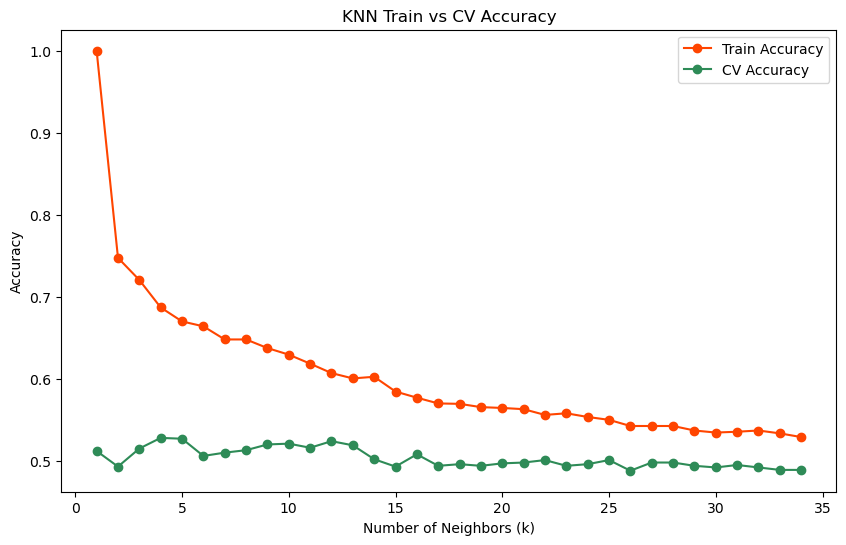

In [106]:
# Extract k values
k_values = param_grid['knn__n_neighbors']

# Extract mean test scores and standard deviation from CV
mean_test_scores = grid.cv_results_['mean_test_score']
std_test_scores = grid.cv_results_['std_test_score']
mean_train_scores = grid.cv_results_['mean_train_score']

plt.figure(figsize=(10,6))
plt.plot(k_values, mean_train_scores, label='Train Accuracy', marker='o',color='orangered')
plt.plot(k_values, mean_test_scores, label='CV Accuracy', marker='o',color='seagreen')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Train vs CV Accuracy")
plt.legend()
plt.show()

In [107]:
# train
knn = KNeighborsClassifier(n_neighbors=19,weights='uniform')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=19)

In [ ]:
# predict
y_pred = knn.predict(X_test_scaled)

# metrics
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Check if there's overfitting
train_score = knn.score(X_train_scaled, y_train)
test_score = knn.score(X_test_scaled, y_test)
print(f"Train accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

Accuracy: 0.6114
Precision: 0.6114
Recall: 0.6114
F1 Score: 0.6104
Train accuracy: 0.6591
Test accuracy: 0.6114


In [ ]:
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
y_pred_str = [bin_labels[i] for i in y_pred]
y_test_str = [bin_labels[j] for j in y_test]

y_pred = pd.Series(y_pred)
results = X_test.reset_index(drop=True).copy()
results['true_rank_coded'] = y_test.reset_index(drop=True)
results['pred_rank_coded'] = y_pred
results['true_rank_coded'] = results['true_rank_coded'].astype(int)
results['pred_rank_coded'] = results['pred_rank_coded'].astype(int)
results['true_rank'] = y_test_str
results['pred_rank'] = y_pred_str
results['correct'] = results['true_rank'] == results['pred_rank']
results['number_of_bins_off'] = results['true_rank_coded'] - results['pred_rank_coded']

wrong_preds = results[results['correct'] == False]

len(wrong_preds)

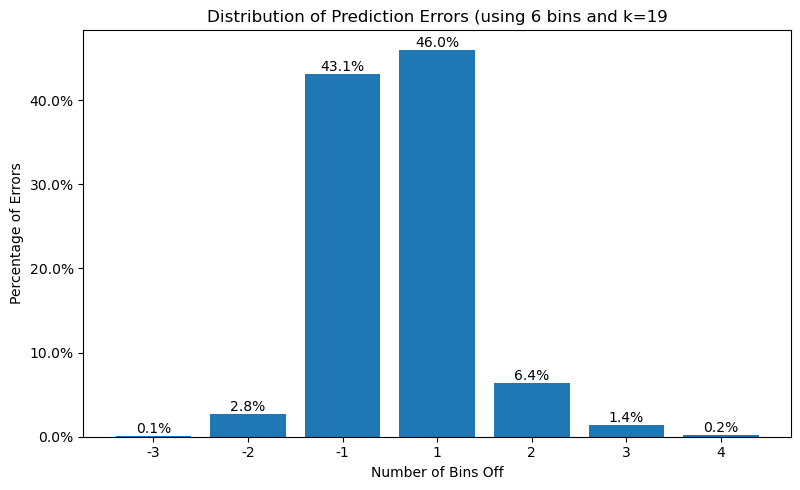

In [113]:
counts = wrong_preds['number_of_bins_off'].value_counts().sort_index()/len(wrong_preds)

plt.figure(figsize=(8,5))
plt.xlabel("Number of Bins Off")
plt.ylabel("Percentage of Errors")
plt.title("Distribution of Prediction Errors (using 6 bins and k=19")
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
bars = plt.bar(counts.index.astype(str), counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1%}",
        ha="center",
        va="bottom"
    )
#plt.show()

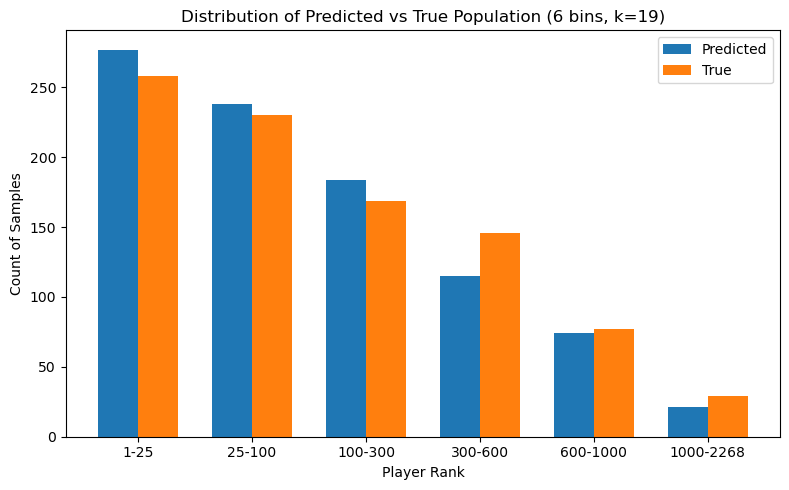

In [114]:
# distribution of pred player_ranks and true player_ranks
pred_counts = wrong_preds['pred_rank_coded'].value_counts()
true_counts = wrong_preds['true_rank_coded'].value_counts()

x = np.arange(len(pred_counts))  # the x locations
width = 0.35  # width of the bars

plt.figure(figsize=(8,5))
plt.bar(x - width/2, pred_counts.values, width=width, label='Predicted')
plt.bar(x + width/2, true_counts.values, width=width, label='True')

plt.xlabel("Player Rank")
plt.ylabel("Count of Samples")
plt.title("Distribution of Predicted vs True Population (6 bins, k=19)")
plt.xticks(x, bin_labels)
plt.legend()
plt.tight_layout()
plt.show()


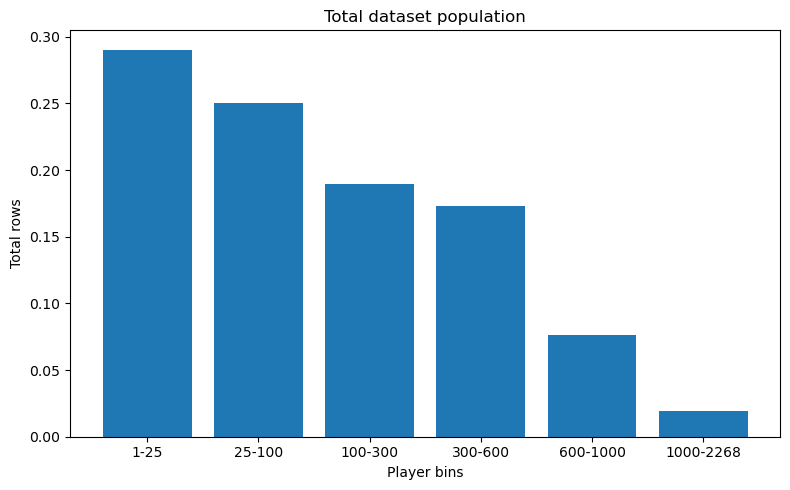

In [115]:
# Count occurrences of each binned rank
pred_counts = results['pred_rank_coded'].value_counts() / len(results)

x = np.arange(len(pred_counts))  # x positions
width = 0.8

plt.figure(figsize=(8,5))
plt.bar(x, pred_counts.values, width=width)

plt.xlabel("Player bins")
plt.ylabel("Total rows")
plt.title("Total dataset population")

# Use your string bin labels on the x-axis
plt.xticks(x, bin_labels)

plt.tight_layout()
plt.show()

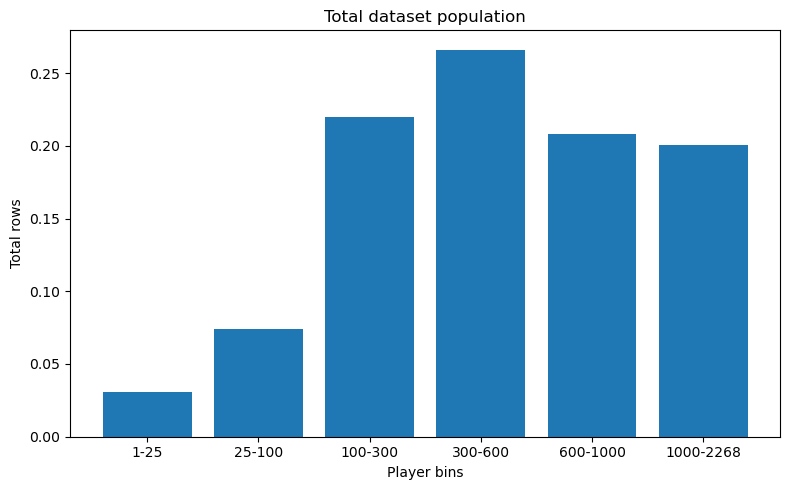

In [116]:
# Count occurrences of each binned rank
counts = df_encoded['binned_rank'].value_counts().sort_index() / len(df_encoded)

x = np.arange(len(counts))  # x positions
width = 0.8

plt.figure(figsize=(8,5))
plt.bar(x, counts.values, width=width)

plt.xlabel("Player bins")
plt.ylabel("Total rows")
plt.title("Total dataset population")

# Use your string bin labels on the x-axis
plt.xticks(x, bin_labels)

plt.tight_layout()
plt.show()

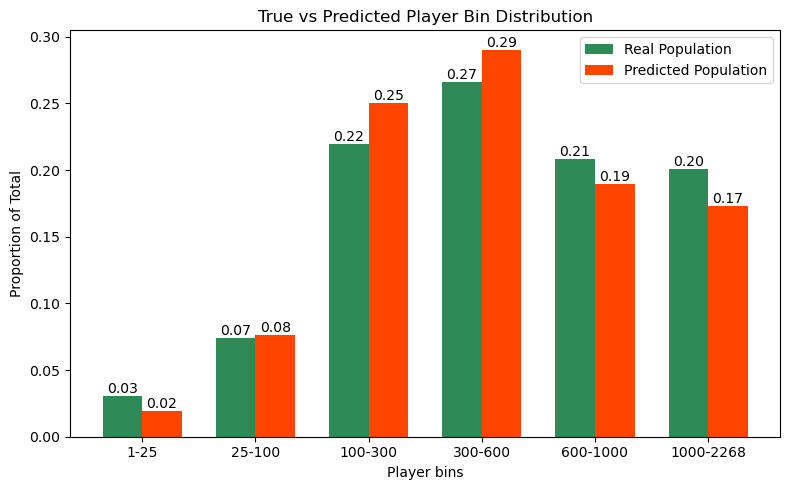

In [117]:
# True distribution
counts = df_encoded['binned_rank'].value_counts().sort_index() / len(df_encoded)

# Predicted distribution
pred_counts = results['pred_rank_coded'].value_counts().sort_index() / len(results)

x = np.arange(len(counts))  # x positions
width = 0.35  # width of bars

plt.figure(figsize=(8,5))
bars_true = plt.bar(x - width/2, counts.values, width=width, label='Real Population', color='seagreen')
bars_pred = plt.bar(x + width/2, pred_counts.values, width=width, label='Predicted Population', color='orangered')

plt.xlabel("Player bins")
plt.ylabel("Proportion of Total")
plt.title("True vs Predicted Player Bin Distribution")
plt.xticks(x, bin_labels)
plt.legend()
plt.tight_layout()

# Add labels on top of the bars
for bar in bars_true:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

for bar in bars_pred:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

plt.show()


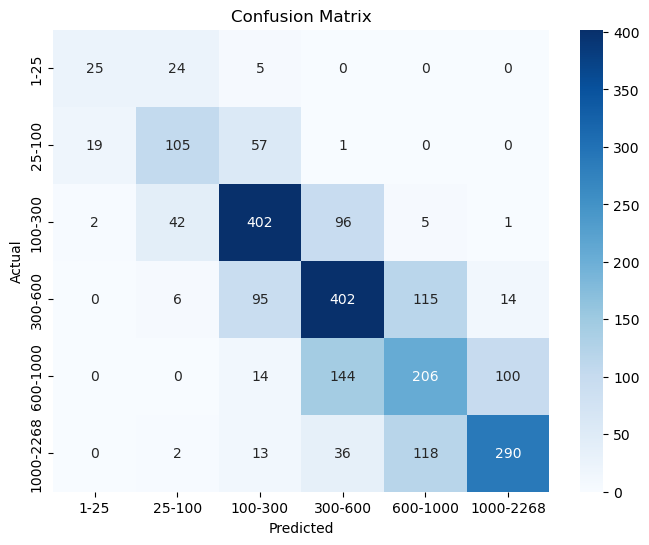

In [118]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=bin_labels,yticklabels=bin_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [119]:
wrong_preds

,match_num,player_age,days_of_experience,draw_size_rolling_med_10,highest_finish_position_rolling_med_10,elo_pre_match_rolling_mean_10,opponent_elo_pre_match_rolling_mean_10,set_dominance_rolling_mean_10,tb_dominance_rolling_mean_10,mean_numb_rolling_mean_10,...,tourney_level_G,tourney_level_M,tourney_level_O,tourney_level_S,true_rank_coded,pred_rank_coded,true_rank,pred_rank,correct,number_of_bins_off
0,18,32.0,5159,32.0,9.0,1564.971984,1639.428916,0.400000,0.500000,4.066667,...,0.0,0.0,0.0,1.0,4,3,600-1000,300-600,False,1
1,289,20.0,1022,32.0,7.0,1594.155964,1655.709957,0.433333,0.333333,4.666667,...,0.0,0.0,0.0,1.0,4,5,600-1000,1000-2268,False,-1
5,9,18.0,672,32.0,9.0,1529.837475,1632.908405,0.500000,0.000000,4.300000,...,0.0,0.0,0.0,1.0,4,5,600-1000,1000-2268,False,-1
8,111,25.0,2310,32.0,9.0,1424.601538,1588.124268,0.333333,0.000000,4.129630,...,0.0,0.0,0.0,0.0,5,4,1000-2268,600-1000,False,1
14,7,28.0,2107,32.0,7.0,1548.713474,1653.390258,0.500000,1.000000,4.683333,...,0.0,0.0,0.0,1.0,4,3,600-1000,300-600,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,12,22.0,1617,32.0,9.0,1465.795089,1618.298386,0.400000,0.000000,3.916667,...,0.0,0.0,0.0,1.0,5,4,1000-2268,600-1000,False,1
2331,109,27.0,3654,32.0,7.0,1730.893320,1601.517738,0.400000,0.666667,4.383333,...,0.0,0.0,0.0,0.0,3,4,300-600,600-1000,False,-1
2335,6,20.0,1134,32.0,9.0,1597.679309,1597.275273,0.466667,1.000000,3.933333,...,0.0,0.0,0.0,0.0,3,2,300-600,100-300,False,1
2336,1,26.0,3913,32.0,3.0,1926.418407,1866.066245,0.600000,0.750000,5.100000,...,0.0,0.0,0.0,1.0,2,3,100-300,300-600,False,-1
